# Cloud removal Analisys

In [1]:
import random
from pathlib import Path

import pandas as pd

from utils.plots import (
    plot_monthly_water,
    plot_tif,
    plot_water_over_time,
    plot_water_x_cloud_percent,
    plot_water_x_cloud_percent_filter,
    plot_water_x_cloud_percent_over_time,
    plot_year_x_variable,
)
from utils.water import calculate_water_area


## Constants

In [2]:
root = Path("../data/02_boa_images/sume_reservatorio")
metadata_path = root / "metadata" / "sentinel_6B_BOA_S2_SR_sume_reservatorio.csv"
PATH_SHAPEFILE = Path(
    "/media/weverton/D/Dev/python/Remote Sensing/tcc/GeoPipe/data/00_shapefiles/sume_reservatorio.geojson"
)
THRESHOLD = 25

In [3]:
root.resolve(), metadata_path.resolve()

(WindowsPath('C:/Users/weverton.vitor/Documents/faculdade/pibic/fmask-pipeline/data/02_boa_images/sume_reservatorio'),
 WindowsPath('C:/Users/weverton.vitor/Documents/faculdade/pibic/fmask-pipeline/data/02_boa_images/sume_reservatorio/metadata/sentinel_6B_BOA_S2_SR_sume_reservatorio.csv'))

In [4]:
metadata = pd.read_csv(metadata_path.resolve())
metadata = metadata[['PRODUCT_ID', 'image_id', "location_name", 'file_name', 'CLOUDY_PIXEL_PERCENTAGE', 'CLOUD_COVERAGE_ASSESSMENT']]
metadata['water_mask_image_path'] = metadata.apply(lambda x: x['file_name'].replace('02_boa_images', '07_water_masks'), axis=1)
metadata['date'] = metadata.apply(lambda x: Path(x['file_name']).name.split('_')[-1].split('.')[0], axis=1)
metadata['year'] = metadata['date'].apply(lambda date: int(f"{date[:4]}"))
metadata['month'] = metadata['date'].apply(lambda date: int(f"{date[4:6]}"))
metadata['day'] = metadata['date'].apply(lambda date: int(f"{date[6:]}"))

metadata.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\weverton.vitor\\Documents\\faculdade\\pibic\\fmask-pipeline\\data\\02_boa_images\\sume_reservatorio\\metadata\\sentinel_6B_BOA_S2_SR_sume_reservatorio.csv'

In [ ]:
metadata["file_name_clean"] = metadata["file_name"].apply(
    lambda x: x.replace("02_boa_images", "04_clean_images").replace(
        ".tif", "_clean.tif"
    )
)
metadata["water_mask_image_path_fmask"] = metadata[
    "water_mask_image_path"
].apply(
    lambda x: x.replace(".tif", "_clean.tif").replace("sume_reservatorio", "sume_reservatorio_deepwatermap_fmask", 1)
)
metadata["water_mask_image_path"] = metadata["water_mask_image_path"].apply(
    lambda x: x.replace(
        "sume_reservatorio", "sume_reservatorio_deepwatermap_no_preprocess", 1
    )
)


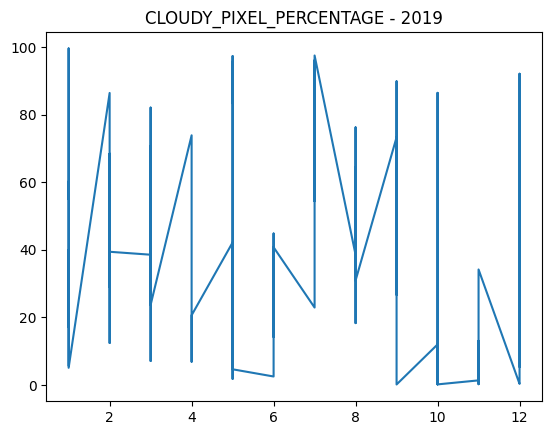

In [ ]:
plot_year_x_variable(data=metadata, year=2019)

## Cloud distribution 

<Axes: >

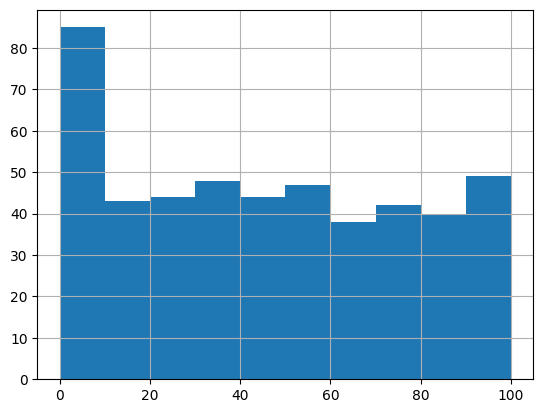

In [ ]:
metadata['CLOUDY_PIXEL_PERCENTAGE'].hist()

## Water Area of DeepWaterMap Without Cloud  Removal

/media/weverton/D/Dev/python/Remote Sensing/tcc/GeoPipe/data/02_boa_images/sume_reservatorio/2021/sentinel_6B_BOA_S2_SR_sume_reservatorio_20210204.tif
/media/weverton/D/Dev/python/Remote Sensing/tcc/GeoPipe/data/07_water_masks/sume_reservatorio_deepwatermap_no_preprocess/2021/sentinel_6B_BOA_S2_SR_sume_reservatorio_20210204.tif
Água(m^2): 5710057.913825592
Água(km^2): 5.710057913825592


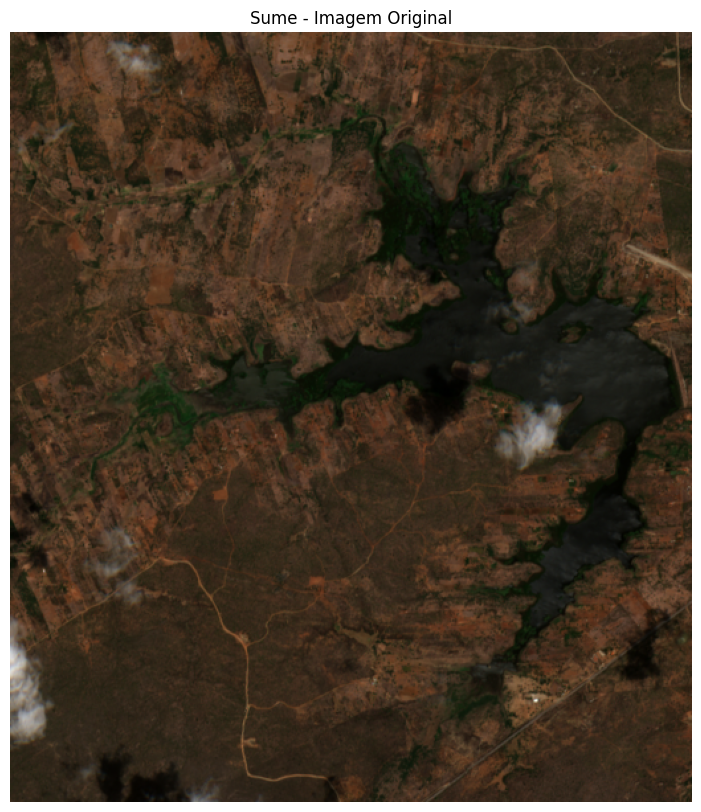

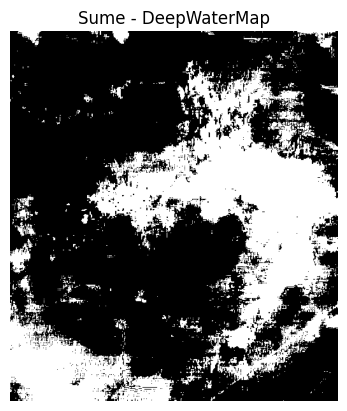

In [ ]:
images = metadata['file_name']
images_water_mask = metadata['water_mask_image_path']
rand = random.randint(0, len(images))

m2, km2 = calculate_water_area(
    images_water_mask[rand], path_shapefile=PATH_SHAPEFILE, binarization_gt=THRESHOLD
)
print(images[rand])
print(images_water_mask[rand])
print(f"Água(m^2): {m2}")
print(f"Água(km^2): {km2}")
plot_tif(images[rand], bandas=[4, 3, 2], titulo="Sume - Imagem Original")
plot_tif(images_water_mask[rand], titulo="Sume - DeepWaterMap", binarization_gt=THRESHOLD)

### Water Area For Many Scenes

In [ ]:
m2_areas = []
km2_areas = []
for index, row in metadata.iterrows():
    m2, km2 = calculate_water_area(
        row['water_mask_image_path'],
          path_shapefile=PATH_SHAPEFILE,
          binarization_gt=THRESHOLD)
    m2_areas.append(m2)  # Convert m^2 to km^2
    km2_areas.append(km2)

metadata['m2_area_deepwatermap'] = pd.Series(m2_areas)
metadata['km2_area_deepwatermap'] = pd.Series(km2_areas)

In [ ]:
metadata[["m2_area_deepwatermap", "km2_area_deepwatermap"]]

,m2_area_deepwatermap,km2_area_deepwatermap
0,7.454560e+06,7.454560
1,9.651077e+06,9.651077
2,8.685063e+06,8.685063
3,6.314420e+06,6.314420
4,3.544877e+06,3.544877
...,...,...
475,9.776029e+06,9.776029
476,9.776029e+06,9.776029
477,9.770018e+06,9.770018
478,9.437042e+06,9.437042


#### Saving Areas to CSV

In [ ]:
try:
    areas = pd.read_csv('./data/areas.csv')
    areas["year"] = metadata["year"]
    areas["month"] = metadata["month"]
    areas["m2_area_deepwatermap"] = metadata["m2_area_deepwatermap"]
    areas["km2_area_deepwatermap"] = metadata["km2_area_deepwatermap"]
    areas["CLOUDY_PIXEL_PERCENTAGE"] = metadata["CLOUDY_PIXEL_PERCENTAGE"]
    areas.to_csv('./data/areas.csv', index=False)
except FileNotFoundError:
    metadata[["m2_area_deepwatermap", "km2_area_deepwatermap"]].to_csv('./data/areas.csv', index=False)

#### Plots

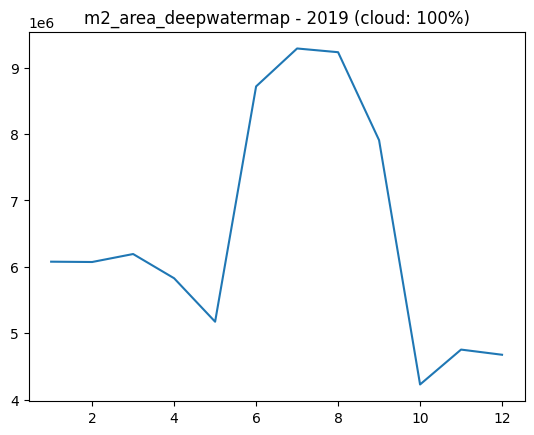

In [ ]:
plot_water_x_cloud_percent_filter(data=metadata, year=2019, y_varible="m2_area_deepwatermap", cloud_percent=100)

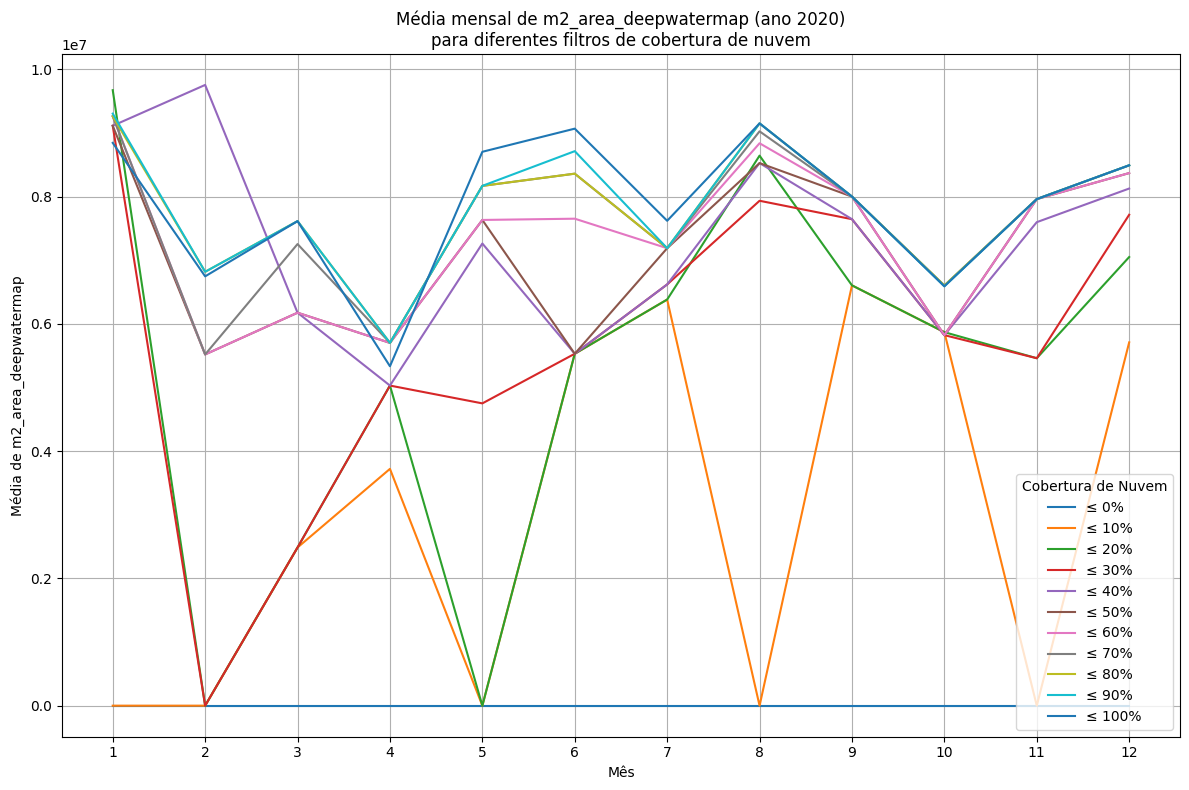

In [ ]:
plot_water_x_cloud_percent(metadata, year=2020, y_variable='m2_area_deepwatermap')


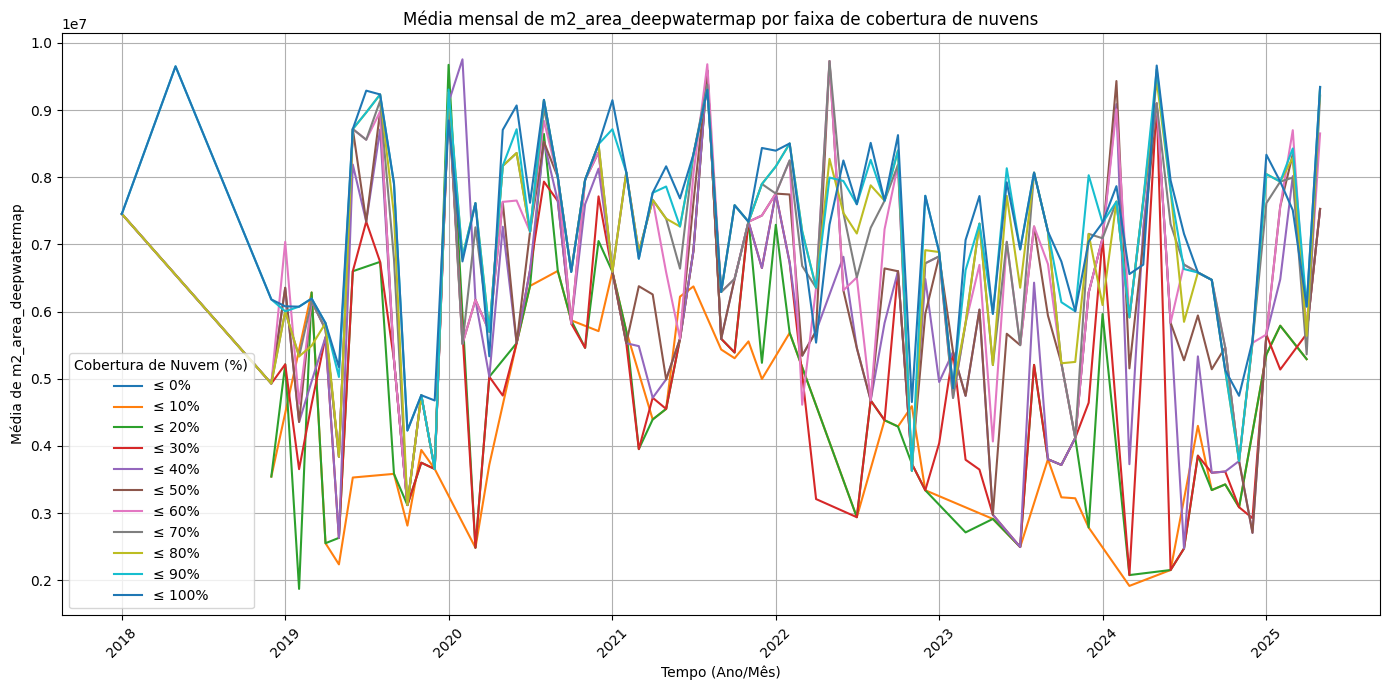

In [ ]:
plot_water_x_cloud_percent_over_time(metadata, y_variable='m2_area_deepwatermap')

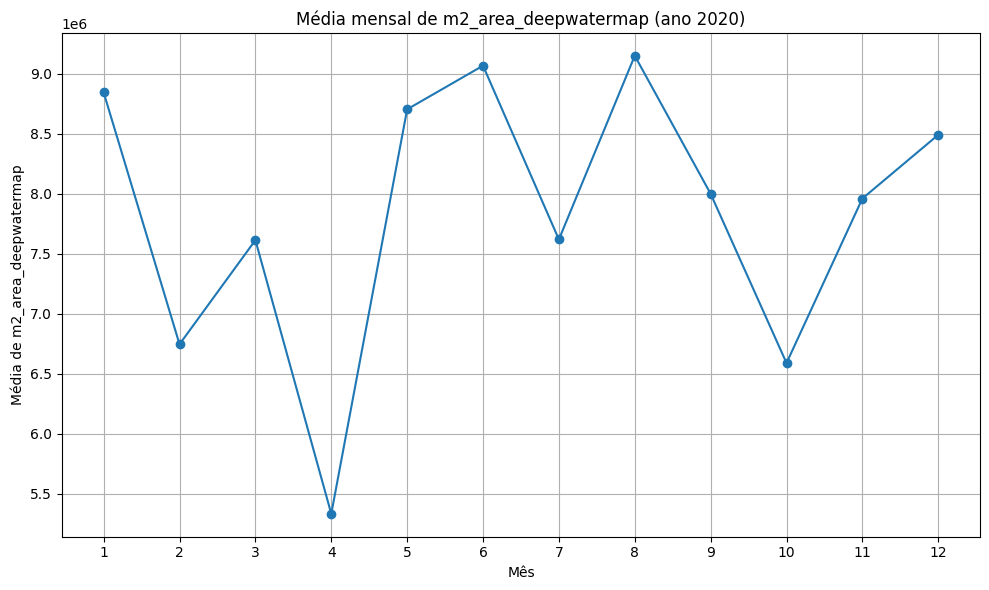

In [ ]:
plot_monthly_water(metadata, year=2020, y_variable='m2_area_deepwatermap')

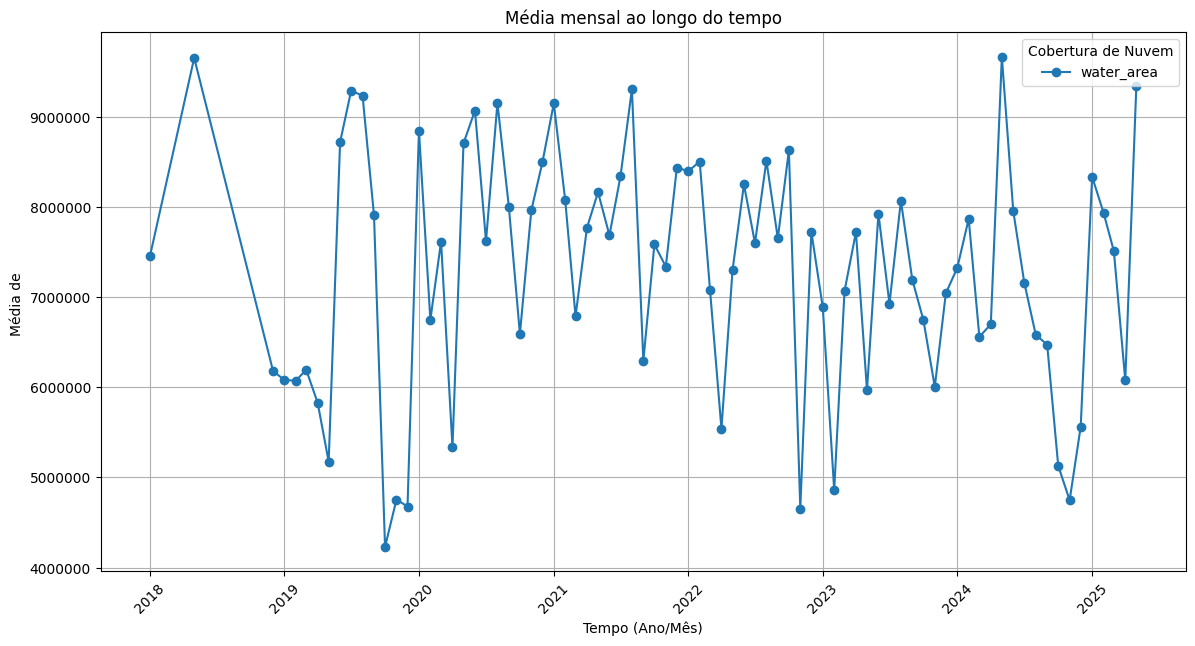

In [ ]:
plot_water_over_time(metadata, y_variables=['m2_area_deepwatermap'])

## Water Area of DeepWaterMap With Cloud Removal

/media/weverton/D/Dev/python/Remote Sensing/tcc/GeoPipe/data/04_clean_images/sume_reservatorio/2019/sentinel_6B_BOA_S2_SR_sume_reservatorio_20190903_clean.tif
/media/weverton/D/Dev/python/Remote Sensing/tcc/GeoPipe/data/07_water_masks/sume_reservatorio_deepwatermap_fmask/2019/sentinel_6B_BOA_S2_SR_sume_reservatorio_20190903_clean.tif
Água(m^2): 2217901.0003705686
Água(km^2): 2.217901000370569


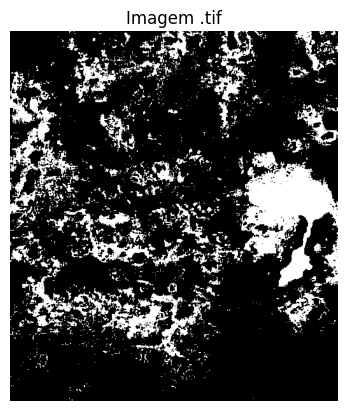

In [ ]:
images = metadata['file_name_clean']
images_water_mask = metadata['water_mask_image_path_fmask']
rand = random.randint(0, len(images))

m2, km2 = calculate_water_area(
    images_water_mask[rand], path_shapefile=PATH_SHAPEFILE, binarization_gt=THRESHOLD
)
print(images[rand])
print(images_water_mask[rand])
print(f"Água(m^2): {m2}")
print(f"Água(km^2): {km2}")
plot_tif(images_water_mask[rand], binarization_gt=THRESHOLD)

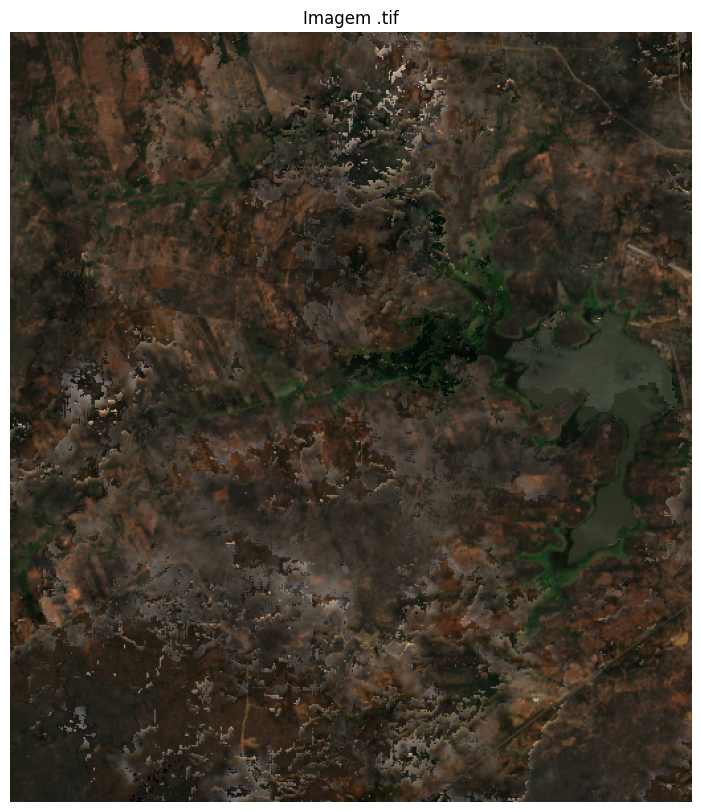

In [ ]:
plot_tif(images[rand], bandas=[4, 3, 2])

### Water Area For Many Scenes

In [ ]:
m2_areas = []
km2_areas = []
for index, row in metadata.iterrows():
    try:
        m2, km2 = calculate_water_area(row['water_mask_image_path_fmask'], path_shapefile=PATH_SHAPEFILE, binarization_gt=THRESHOLD)
        m2_areas.append(m2)
        km2_areas.append(km2)
    except Exception as e:
        print(e)
        print(f"Error to calculate water area of {row['water_mask_image_path_fmask']}")

metadata['m2_area_fmask_deepwatermap'] = pd.Series(m2_areas)
metadata['km2_area_fmask_deepwatermap'] = pd.Series(km2_areas)

/media/weverton/D/Dev/python/Remote Sensing/tcc/GeoPipe/data/07_water_masks/sume_reservatorio_deepwatermap_fmask/2018/sentinel_6B_BOA_S2_SR_sume_reservatorio_20180106_clean.tif: No such file or directory
Error to calculate water area of /media/weverton/D/Dev/python/Remote Sensing/tcc/GeoPipe/data/07_water_masks/sume_reservatorio_deepwatermap_fmask/2018/sentinel_6B_BOA_S2_SR_sume_reservatorio_20180106_clean.tif
/media/weverton/D/Dev/python/Remote Sensing/tcc/GeoPipe/data/07_water_masks/sume_reservatorio_deepwatermap_fmask/2018/sentinel_6B_BOA_S2_SR_sume_reservatorio_20180531_clean.tif: No such file or directory
Error to calculate water area of /media/weverton/D/Dev/python/Remote Sensing/tcc/GeoPipe/data/07_water_masks/sume_reservatorio_deepwatermap_fmask/2018/sentinel_6B_BOA_S2_SR_sume_reservatorio_20180531_clean.tif
/media/weverton/D/Dev/python/Remote Sensing/tcc/GeoPipe/data/07_water_masks/sume_reservatorio_deepwatermap_fmask/2018/sentinel_6B_BOA_S2_SR_sume_reservatorio_20181217_clean

In [ ]:
metadata[["m2_area_fmask_deepwatermap", "km2_area_fmask_deepwatermap"]]

,m2_area_fmask_deepwatermap,km2_area_fmask_deepwatermap
0,4.735766e+06,4.735766
1,4.675754e+06,4.675754
2,3.807888e+06,3.807888
3,1.168421e+06,1.168421
4,3.709049e+06,3.709049
...,...,...
475,4.131798e+06,4.131798
476,4.239308e+06,4.239308
477,NaN,NaN
478,NaN,NaN


#### Saving Areas to CSV

In [ ]:
try:
    areas = pd.read_csv('./data/areas.csv')
    areas["year"] = metadata["year"]
    areas["month"] = metadata["month"]
    areas["m2_area_fmask_deepwatermap"] = metadata["m2_area_fmask_deepwatermap"]
    areas["km2_area_fmask_deepwatermap"] =metadata["km2_area_fmask_deepwatermap"]
    areas.to_csv('./data/areas.csv', index=False)
except FileNotFoundError:
    metadata[["m2_area_fmask_deepwatermap", "km2_area_fmask_deepwatermap"]].to_csv('./data/areas.csv', index=False)

#### Plots

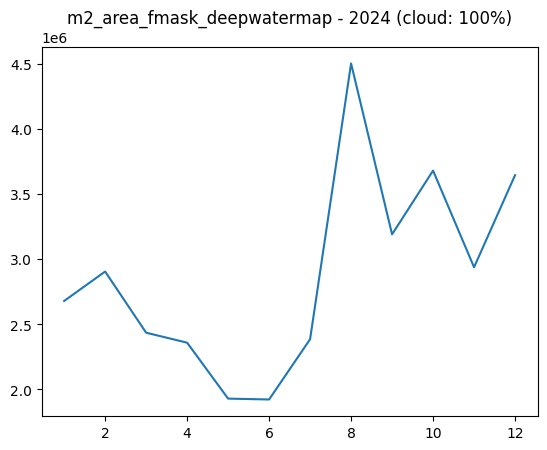

In [ ]:
plot_water_x_cloud_percent_filter(data=metadata, year=2024, y_varible='m2_area_fmask_deepwatermap', cloud_percent=100)

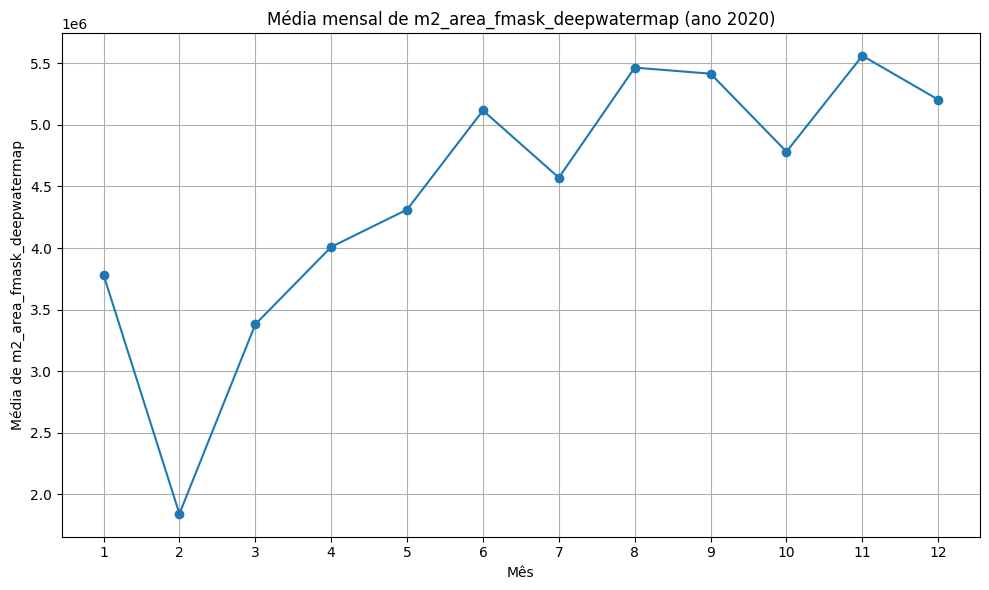

In [ ]:
plot_monthly_water(metadata, year=2020, y_variable='m2_area_fmask_deepwatermap')

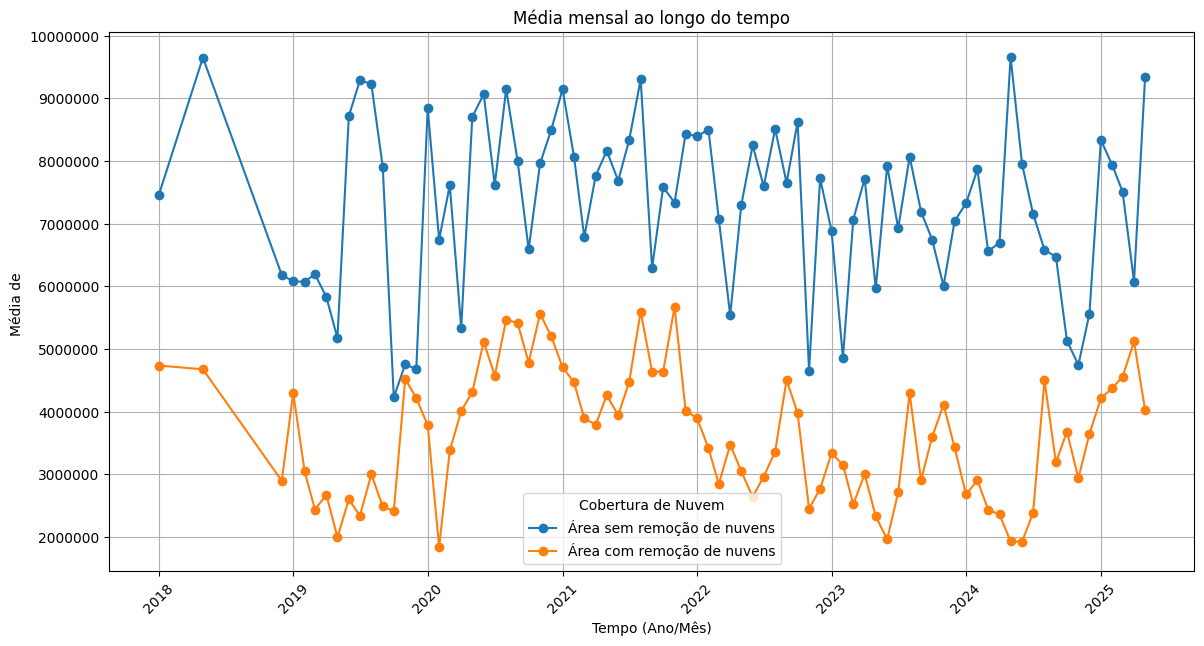

In [ ]:
plot_water_over_time(metadata, y_variables=['m2_area_deepwatermap', 'm2_area_fmask_deepwatermap'], labels=['Área sem remoção de nuvens', 'Área com remoção de nuvens'])

## Volume